In [1]:
!nvidia-smi

Thu Apr 15 08:43:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#Create classes and functions, load perceptual loss network

In [3]:
%cd /content/drive/My\ Drive/ML_Ultrasound_Project/UROPdata

/content/drive/My Drive/ML_Ultrasound_Project/UROPdata


In [4]:
!pip install torchsummaryX --quiet

In [6]:
# Import libraries
from networks.convlstm import RNN
from networks.loss_net import LossNetwork

import numpy as np
import math
import numbers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.lines
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import torch
from torch import Tensor
from torch import nn
import torch.nn.functional as F
from torch.nn.modules.utils import _pair
from torch import optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.nn import Parameter
from torchvision.models import vgg
import torchvision.transforms as transforms
from torchvision.transforms.functional import hflip
from torchvision.transforms.functional import vflip
from torchvision.transforms.functional import rotate

from sklearn import preprocessing
from sklearn.model_selection import KFold
from scipy.ndimage import gaussian_filter
from torchsummaryX import summary
from tqdm.notebook import tqdm
from collections import namedtuple
from PIL import ImageFilter

import time
import random
import os
import collections

torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [7]:
# Data must be stored on GPU to use GPU for training
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [9]:
# Generator
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))


In [10]:
def loss_batch(model, loss_network, loss_func, xb, yb, opt=None):

    # plt.figure()
    # plt.imshow(np.rot90(np.fliplr(yb[:,:,0].to('cpu').detach().numpy())))
    # plt.show()

    predictions = (model(xb)+1)/2
    targets = (yb.squeeze(2)+1)/2

    pred_labels, labels = reshape_for_loss_net(predictions, targets)

    features_pred_labels = loss_network(pred_labels)
    features_labels = loss_network(labels)

    with torch.no_grad():
        f_labels = features_labels[1].detach()

    loss = loss_func(features_pred_labels[1], f_labels)
    # criterion = nn.MSELoss()
    # rmse = torch.sqrt(criterion(features_pred_labels[1], f_labels))

    # loss = rmse#torch.mean(torch.stack([loss, rmse]))

    if opt != None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [11]:
def reshape_for_loss_net(pred_yb, yb):

    pred_yb = pred_yb.repeat(1,3,1,1)
    pred_yb = pred_yb.repeat_interleave(10, dim=2)
    pred_yb = pred_yb.repeat_interleave(23, dim=3)
    yb = yb.repeat(1,3,1,1)
    yb = yb.repeat_interleave(10, dim=2)
    yb = yb.repeat_interleave(23, dim=3)

    # normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # pred_yb = normalize(pred_yb)
    # yb = normalize(yb)

    # print('Label ', yb.shape)
    # plt.figure()
    # plt.imshow(np.rot90(yb[0,0,].to('cpu').detach().numpy()))
    # plt.show()

    # print('Predicted label')
    # plt.figure()
    # plt.imshow(np.rot90(pred_yb[0,0,].to('cpu').detach().numpy()))
    # plt.show()
    
    return pred_yb, yb


In [12]:
# Fit model
def fit(epochs, model, loss_network, loss_func, opt, train_dl, valid_dl, batches, verbose):
    train_losses = []
    validation_losses = []

    # liveloss = PlotLosses()
    
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch+1, epochs))

        logs = {}
      
        batch = 1
        
        model.train()

        loss = 0

        # With progress bar
        if verbose == 1:
            for xb, yb in tqdm(train_dl):
                batch_loss, batch_size = loss_batch(model, loss_network, loss_func, xb, yb, opt)
                loss += batch_loss              
                print('{}/{}'.format(batch, batches), end="\r")
                batch+=1

        # Without progress bar
        if verbose == 2:
            for xb, yb in train_dl:
                batch_loss, batch_size = loss_batch(model, loss_network, loss_func, xb, yb, opt)
                loss += batch_loss                
                print('{}/{}'.format(batch, batches), end="\r")
                batch+=1       

        loss=loss/len(train_dl)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_network, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        train_losses.append(loss)
        validation_losses.append(val_loss)

        print('loss = {}      val_loss: {}'.format(loss, val_loss))

        # logs['log loss'] = loss
        # logs['val_log loss'] = val_loss

        # liveloss.update(logs)
        # liveloss.send()

        if (epoch+1)%25 == 0 and epoch > 0:
          torch.save(model.state_dict(), '/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/rnn14_state_dict_zeroed_{}'.format(epoch+1))
          torch.save(opt.state_dict(), '/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/rnn14_opt_state_dict_zeroed_{}'.format(epoch+1))
          print('Saved state dict')
          
        # Plot training curve for loss
        plt.plot(train_losses[:])
        plt.plot(validation_losses[:])
        plt.title('loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.yscale('log')
        plt.legend(['train', 'validation'], loc = 'upper right')
        plt.show()

    return train_losses, validation_losses

In [13]:
def k_fold_train(x_train, y_train, loss_network, bs, batches, verbose):
    
    # Data must be stored on GPU to use GPU for training
    dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    # kfold = KFold(n_splits=20)

    # k_train_losses = []
    # k_val_losses = []

    # for fold, (train_index, valid_index) in enumerate(kfold.split(x_train, y_train)):

    fold = 0
        
    ### Dividing data into folds
    x_train_fold = x_train[8700:]
    x_valid_fold = x_train[:8700]
    y_train_fold = y_train[8700:]
    y_valid_fold = y_train[:8700]

    train_ds = TensorDataset(x_train_fold, y_train_fold)
    valid_ds = TensorDataset(x_valid_fold, y_valid_fold)

    train_dl, valid_dl = get_data(train_ds, valid_ds, bs)

    train_dl = WrappedDataLoader(train_dl, preprocess)
    valid_dl = WrappedDataLoader(valid_dl, preprocess)

    # CNN model
    model = RNN()
    # Store model on GPU for training
    model.to(dev)
    # model.load_state_dict(torch.load('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/rnn12_state_dict_zeroed_175'))

    # Hyperparameters
    loss_func = nrmse_loss#custom_loss
    learning_rate = 1e-3
    EPOCHS = 500
    opt = optim.Adam(model.parameters(), lr=learning_rate)
    # opt.load_state_dict(torch.load('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/rnn12_opt_state_dict_zeroed_175'))

    print('K-fold: {}/5'.format(fold+1))

    train_losses, val_losses = fit(EPOCHS, model, loss_network, loss_func, opt, train_dl, valid_dl, batches, verbose)

    k_train_losses.append(train_losses)
    k_val_losses.append(val_losses)

    # torch.save(cnn.state_dict(), '/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/cnn_state_dict_thirties_content_loss_k{}_9'.format(fold))

    return k_train_losses, k_val_losses


In [14]:
def preprocess(x, y):
    return x.view(-1, 9, 1, 23, 23).to(dev), y.to(dev)

In [15]:
def get_data(train_ds, valid_ds, bs):
    # Removed shuffle=True for train_ds - ensures batches are related
    return (
        DataLoader(train_ds, batch_size=bs),
        DataLoader(valid_ds, batch_size=bs),
    )

In [16]:
# NRMSE loss function
def nrmse_loss(y_pred, y_true):
    diff = torch.div(y_pred - y_true, torch.max(y_true) - torch.min(y_true) + 1e-6)
    return torch.sqrt(torch.mean(torch.square(diff)))

In [17]:
def custom_loss(y_pred, y_true):
    w = 0.5
    false_zero = -0.08734477

    error = nrmse_loss(y_pred, y_true)
    error = torch.where((y_true<false_zero*-1.1 and y_true>false_zero*-0.9), error, error*w)

    return torch.mean(error)

In [18]:
vgg_model = vgg.vgg16(pretrained=True)
# # Replace MaxPool layers with AvgPool
# for layer in [4, 9, 16, 23, 30]:
#   vgg_model.features[layer] = nn.AvgPool2d(vgg_model.features[layer].kernel_size)
vgg_model.to(dev)
loss_network = LossNetwork(vgg_model)
loss_network.eval()

# summary(loss_network, torch.zeros(64,3,60,66).to(dev))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


LossNetwork(
  (vgg_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, 

#Load training data and train CNN

(129600, 2)
Training labels


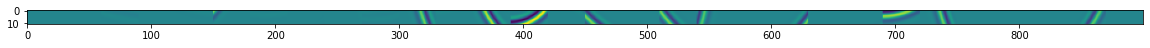

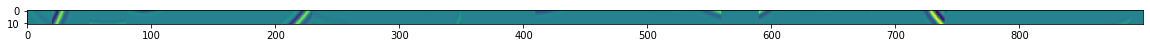

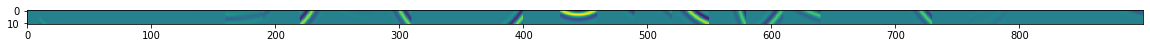

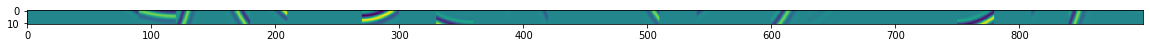

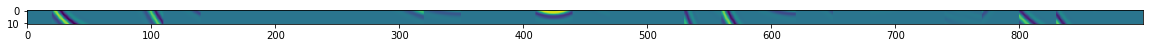

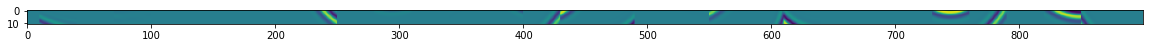

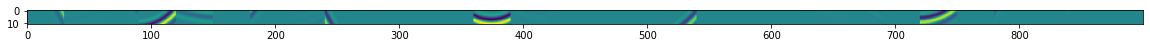

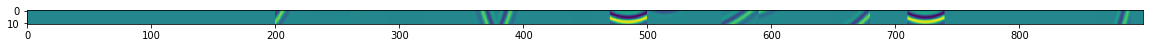

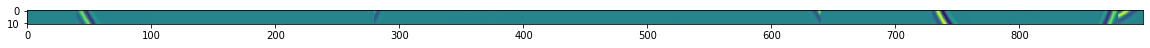

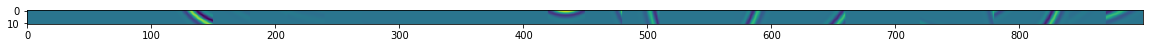

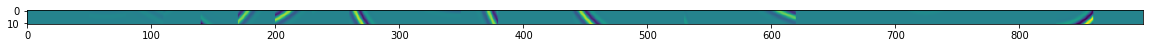

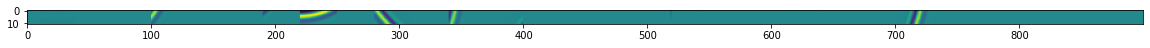

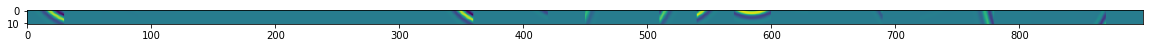

torch.Size([129600, 1, 9, 23, 23]) torch.Size([129600, 11, 1])


In [35]:
# Load dataset created from notebook 'Debias_Data'
t_data = np.load('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/training_data_all_zeroed.npz', allow_pickle=True)

training_data = t_data['arr_0'] # saves the array from t_data file
print(training_data.shape)


# This part reorganises the array into input and label arrays, mainly to help it feed into model with correct shapes
# For training data
train_X = []
train_Y = []

for i in range (len(training_data)):
  train_X.append(training_data[i][0])
  train_Y.append(training_data[i][1])

x_train, y_train = map(
    torch.cuda.FloatTensor, (train_X[:], train_Y[:])
)

print('Training labels')
train_Y = np.array(train_Y)
for i in range(0, len(train_Y), 10000):
  plt.figure(figsize=(20,20))
  plt.imshow(np.rot90(train_Y[i:i+900,].squeeze()))
  plt.show()

# Add axis to training and validation arrays
x_train = x_train.unsqueeze(1)

# Check correct shape
print(x_train.shape, y_train.shape)



In [ ]:
# Train model with k-fold validation
batch_size = 30
batches = math.ceil(len(train_X)/batch_size)
verbose = 2       # 1: progress bar, 2: without progress bar

k_train_losses, k_val_losses = k_fold_train(x_train, y_train, loss_network, batch_size, batches, verbose)

In [ ]:
# # Plot training curves for k folds
# for i in range(5):
#     plt.plot(k_train_losses[i][:])
#     plt.plot(k_val_losses[i][:])
#     plt.title('K-fold: {}'.format(i))
#     plt.ylabel('loss')
#     plt.xlabel('epoch')
#     plt.yscale('log')
#     plt.legend(['train', 'validation'], loc = 'upper right')
#     plt.show()

#Load testing data

In [19]:
# Load test dataset
testing_data = np.load('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/test_data_all_zeroed.npz', allow_pickle=True)
test_data = testing_data['arr_0'] 

# Reorganises the array into input and label arrays, same as for training and validation sets
test_X = []
test_Y = []

for i in range (len(test_data)):
  test_X.append(test_data[i][0])
  test_Y.append(test_data[i][1])

x_test, y_test = map(
    torch.cuda.FloatTensor, (test_X[:], test_Y[:])
)

test_Y = np.array(test_Y)

# Add axis to training and validation arrays
x_test = x_test.unsqueeze(1)

# Check correct shape
print(x_test.shape, y_test.shape)


torch.Size([27900, 1, 9, 23, 23]) torch.Size([27900, 11, 1])


In [20]:
test_ds = TensorDataset(x_test, y_test)

test_dl = DataLoader(test_ds, batch_size=30)

test_dl = WrappedDataLoader(test_dl, preprocess)

In [21]:
# Loads the entire dataset of both blank and wave inputs/labels
norm_inputs = np.load('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/norm_inputs_all_zeroed.npz', allow_pickle=True)
norm_labels = np.load('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/norm_labels_all_zeroed.npz', allow_pickle=True)

norm_inputs = norm_inputs['arr_0']
print(norm_inputs.shape)

norm_labels = norm_labels['arr_0']
print(norm_labels.shape)

#Append the normalised input images for 1 complete image to a new array
one_img = []
one_lab = []

#left column: coloured wave images
# Select time step 475
# for i in range (int(475.5*180), 476*180, 1):
for i in range(100000,102000,1):
  one_img.append(norm_inputs[i])
  one_lab.append(norm_labels[i])
print(np.array(one_img).shape, np.array(one_lab).shape)

# PyTorch uses tensors
one_img, one_lab = map(torch.cuda.FloatTensor, (one_img, one_lab))

# Add axis to training and validation arrays
one_img = one_img.unsqueeze(1)

# Check correct shape
print(one_img.shape, one_lab.shape)


(157500, 9, 23, 23)
(157500, 11, 1)
(2000, 9, 23, 23) (2000, 11, 1)
torch.Size([2000, 1, 9, 23, 23]) torch.Size([2000, 11, 1])


In [22]:
one_ds = TensorDataset(one_img, one_lab)

one_dl = DataLoader(one_ds, batch_size=len(one_lab))

one_dl = WrappedDataLoader(one_dl, preprocess)

#Load trained CNN model and test

In [23]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Load saved CNN weights
rnn = RNN()
rnn.to(dev)
rnn.load_state_dict(torch.load('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/rnn12_state_dict_zeroed_200'), strict=False)
rnn.eval()

RNN(
  (convlstm1): CLSTM_cell(
    (conv): Sequential(
      (0): Conv2d(33, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(4, 128, eps=1e-05, affine=True)
    )
  )
  (convlstm2): CLSTM_cell(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(4, 128, eps=1e-05, affine=True)
    )
  )
  (convlstm3): CLSTM_cell(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(4, 128, eps=1e-05, affine=True)
    )
  )
  (convlstm4): CLSTM_cell(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(4, 128, eps=1e-05, affine=True)
    )
  )
  (reshape_output): ProcessOut(
    (tanh): Tanh()
    (flat): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=152352, out_features=11, bias=True)
  )
  (lambda_1): Lambda()
)

Generate predictions using the testing dataset
Test Perceptual Loss: 8.28021258790633e-05
Test NRMSE Loss: 45.744510650634766
----------------------------------------------
Worst perceptual loss:  0.00046124085201881826


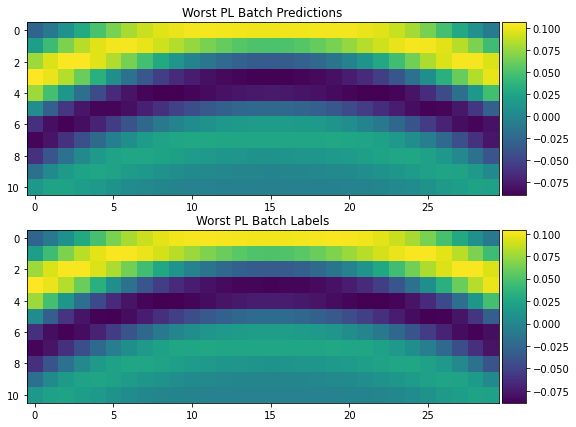

----------------------------------------------
Worst NRMSE loss:  179.2010955810547


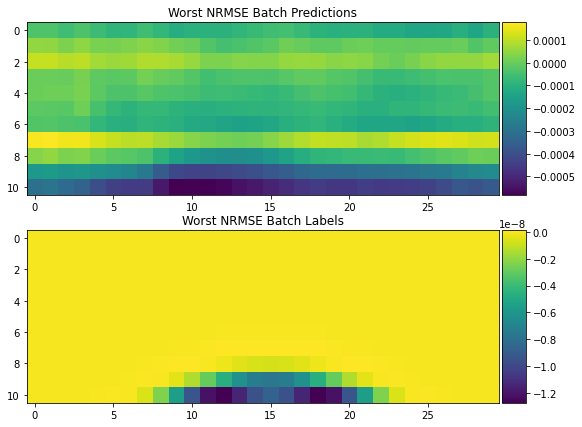

In [24]:
print("Generate predictions using the testing dataset")

predictions = []
batch_loss = 0
batch_nrmse_loss = 0
batches = 0
loss_func = nrmse_loss

max_error = 0
max_nrmse_error = 0

rnn.eval()
for xb, yb in test_dl:
  with torch.no_grad():
      xb = Variable(xb.data, requires_grad=True)

      batch_predictions = rnn(xb)

      predictions.append(batch_predictions.cpu().detach().numpy())

      pred_labels, labels = reshape_for_loss_net((batch_predictions+1)/2, (yb.squeeze(2)+1)/2)

      features_pred_labels = loss_network(pred_labels)
      features_labels = loss_network(labels)

      with torch.no_grad():
          f_labels = features_labels[1].detach()


      perceptual_loss = loss_func(features_pred_labels[1], f_labels).item()
      nrmse = loss_func(batch_predictions, yb.squeeze(2))

      batch_loss += perceptual_loss
      batch_nrmse_loss += nrmse
      batches += 1

      if perceptual_loss > max_error:
        max_error = perceptual_loss
        worst_pred = batch_predictions.cpu().detach().numpy()
        worst_labels = yb.squeeze(2).cpu().detach().numpy()

      if nrmse > max_nrmse_error:
        max_nrmse_error = nrmse
        worst_nrmse_pred = batch_predictions.cpu().detach().numpy()
        worst_nrmse_labels = yb.squeeze(2).cpu().detach().numpy()
        

test_loss = batch_loss / batches
test_nrmse_loss = batch_nrmse_loss / batches

print('Test Perceptual Loss: {}'.format(test_loss))
print('Test NRMSE Loss: {}'.format(test_nrmse_loss))

predictions = np.reshape(predictions, (-1,11))

print('----------------------------------------------')
print('Worst perceptual loss: ', max_error)
fig, ax = plt.subplots(2,1, figsize=(10,7))

divider = make_axes_locatable(ax[0])
cax0 = divider.append_axes("right", size="5%", pad=0.05)
ax[0].set_title('Worst PL Batch Predictions')
im0 = ax[0].imshow(np.rot90(worst_pred, 3))
fig.colorbar(im0, cax=cax0)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes("right", size="5%", pad=0.05)
ax[1].set_title('Worst PL Batch Labels')
im1 = ax[1].imshow(np.rot90(worst_labels, 3))
fig.colorbar(im1, cax=cax1)
plt.show()

print('----------------------------------------------')
print('Worst NRMSE loss: ', max_nrmse_error.item())
fig, ax = plt.subplots(2,1, figsize=(10,7))

divider = make_axes_locatable(ax[0])
cax0 = divider.append_axes("right", size="5%", pad=0.05)
ax[0].set_title('Worst NRMSE Batch Predictions')
im0 = ax[0].imshow(np.rot90(worst_nrmse_pred, 3))
fig.colorbar(im0, cax=cax0)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes("right", size="5%", pad=0.05)
ax[1].set_title('Worst NRMSE Batch Labels')
im1 = ax[1].imshow(np.rot90(worst_nrmse_labels, 3))
fig.colorbar(im1, cax=cax1)
plt.show()


Real labels:


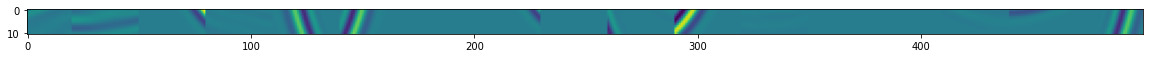

Predicted labels:


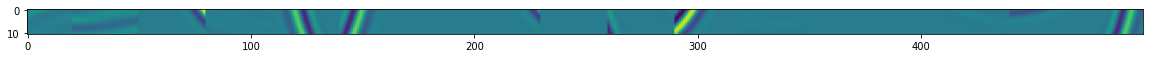

In [25]:
test_Y = test_Y.squeeze()

print("Real labels:")
b = test_Y[20500:21000, ]
b = np.rot90(b)
plt.figure(figsize=(20,3))
plt.imshow(b)
plt.show()

print("Predicted labels:")
a = predictions[20500:21000, ]
a = np.rot90(a)
plt.figure(figsize=(20,3))
plt.imshow(a)
plt.show()

tensor([-4.3275e-05,  4.2396e-05,  1.0751e-04,  1.7321e-05,  5.9776e-06,
        -3.5645e-06, -4.3501e-05,  1.6378e-04,  2.2918e-05, -2.0126e-04,
        -3.4605e-04], device='cuda:0', grad_fn=<SelectBackward>)


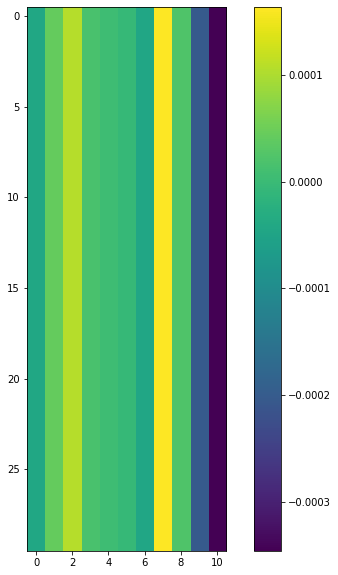

In [26]:
# Check performance at predicting blank (zeros) borders
zeros = torch.cuda.FloatTensor(np.zeros((30,9,1,23,23)))
predZeros = rnn(zeros)
print(predZeros[0])
plt.figure(figsize=(10,10))
plt.imshow(predZeros.cpu().detach().numpy())
plt.colorbar()
plt.show()

Image Perceptual Loss: 9.067635983228683e-05
Image NRMSE Loss: 0.0019197298679500818
----------------------------------------------
Worst perceptual loss:  9.067635983228683e-05


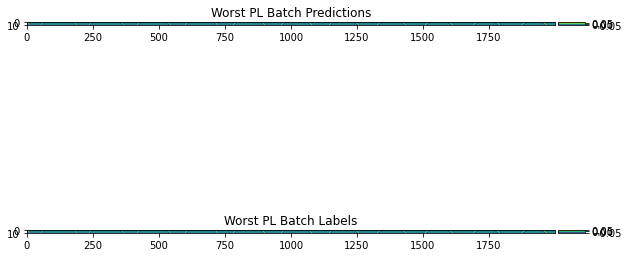

----------------------------------------------
Worst NRMSE loss:  0.0019197298679500818


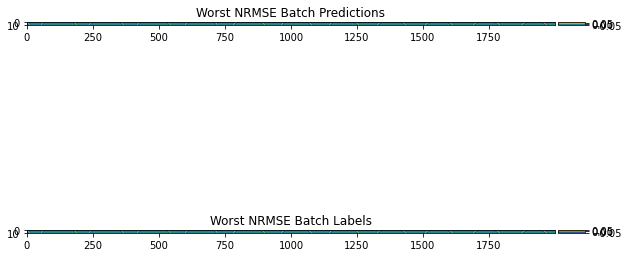

In [27]:
predictions2 = []
batch_loss = 0
batch_nrmse_loss = 0
batches = 0

loss_func = nrmse_loss

max_error = 0
max_nrmse_error = 0

rnn.eval()
for xb, yb in one_dl:
  with torch.no_grad():
      xb = Variable(xb.data, requires_grad=True)

      batch_predictions = rnn(xb)

      predictions2.append(batch_predictions.cpu().detach().numpy())

      pred_labels, labels = reshape_for_loss_net((batch_predictions+1)/2, (yb.squeeze(2)+1)/2)

      features_pred_labels = loss_network(pred_labels)
      features_labels = loss_network(labels)

      with torch.no_grad():
          f_labels = features_labels[1].detach()

      perceptual_loss = loss_func(features_pred_labels[1], f_labels).item()
      nrmse = loss_func(batch_predictions, yb.squeeze(2))

      batch_loss += perceptual_loss
      batch_nrmse_loss += nrmse
      batches += 1

      if perceptual_loss > max_error:
        max_error = perceptual_loss
        worst_pred = batch_predictions.cpu().detach().numpy()
        worst_labels = yb.squeeze(2).cpu().detach().numpy()

      if nrmse > max_nrmse_error:
        max_nrmse_error = nrmse
        worst_nrmse_pred = batch_predictions.cpu().detach().numpy()
        worst_nrmse_labels = yb.squeeze(2).cpu().detach().numpy()

image_loss = batch_loss / batches
image_nrmse_loss = batch_nrmse_loss / batches

print('Image Perceptual Loss: {}'.format(image_loss))
print('Image NRMSE Loss: {}'.format(image_nrmse_loss))

predictions2 = np.reshape(predictions2, (-1,11))


print('----------------------------------------------')
print('Worst perceptual loss: ', max_error)
fig, ax = plt.subplots(2,1, figsize=(10,7))

divider = make_axes_locatable(ax[0])
cax0 = divider.append_axes("right", size="5%", pad=0.05)
ax[0].set_title('Worst PL Batch Predictions')
im0 = ax[0].imshow(np.rot90(worst_pred, 3))
fig.colorbar(im0, cax=cax0)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes("right", size="5%", pad=0.05)
ax[1].set_title('Worst PL Batch Labels')
im1 = ax[1].imshow(np.rot90(worst_labels, 3))
fig.colorbar(im1, cax=cax1)
plt.show()

print('----------------------------------------------')
print('Worst NRMSE loss: ', max_nrmse_error.item())
fig, ax = plt.subplots(2,1, figsize=(10,7))

divider = make_axes_locatable(ax[0])
cax0 = divider.append_axes("right", size="5%", pad=0.05)
ax[0].set_title('Worst NRMSE Batch Predictions')
im0 = ax[0].imshow(np.rot90(worst_nrmse_pred, 3))
fig.colorbar(im0, cax=cax0)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes("right", size="5%", pad=0.05)
ax[1].set_title('Worst NRMSE Batch Labels')
im1 = ax[1].imshow(np.rot90(worst_nrmse_labels, 3))
fig.colorbar(im1, cax=cax1)
plt.show()


In [28]:
one_img = one_img.cpu().detach().numpy()
one_lab = one_lab.cpu().detach().numpy()
one_lab = one_lab.squeeze()

Real Left Column:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  # Remove the CWD from sys.path while we load stuff.


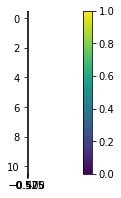

Predicted Left Column:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.


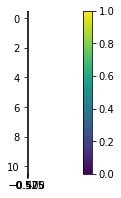

In [29]:
# print('images')
# plt.figure(figsize=(20,3))
# plt.imshow(np.rot90(images[23+23*20:23*30]))
# plt.show()

print("Real Left Column:")
plt.figure(figsize=(20,3))
g = one_lab[40000:40500, :]
g = np.rot90(g)
plt.imshow(g)
plt.colorbar()
plt.show()

print("Predicted Left Column:")
plt.figure(figsize=(20,3))
e = predictions2[40000:40500, :]
e = np.rot90(e)
plt.imshow(e)
plt.colorbar()
plt.show()